<a href="https://colab.research.google.com/github/sahandv/science_science/blob/master/FastText_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FASTTEXT CLUSTERING



## Initialize

### Clone github repo for sciosci

In [0]:
!rm -rf 'science_science'
username = "sahandv"#@param {type:"string"}
# password = ""#@param {type:"string"} 

!git clone https://github.com/$username/science_science.git
!ls

Cloning into 'science_science'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 170 (delta 43), reused 113 (delta 9), pack-reused 0
Receiving objects: 100% (170/170), 22.49 MiB | 15.00 MiB/s, done.
Resolving deltas: 100% (43/43), done.
sample_data  science_science


### Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Install *requirements*

In [0]:
!pip install -r 'science_science/requirements.txt'

### Import Libs

In [0]:
import sys
import time
import gc
from google.colab import files
import collections
import json
import re
import os
import pprint
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as sch
from scipy import spatial,sparse,sign

from bokeh.io import push_notebook, show, output_notebook, output_file
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

from science_science.sciosci.assets import keyword_assets as kw
from science_science.sciosci.assets import generic_assets as sci
from science_science.sciosci.assets import advanced_assets as aa

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load and Prepare Embeddings

#### Option A -  Load Corpus Vector Data

In [0]:
file_address = 'drive/My Drive/Data/corpus/improved_copyr_lemmatized_stopword_removed_thesaurus/FastText vector 1990-2018.json'
with open(file_address) as f:
    vectors = json.loads(f.read())

#### Option B - Load Document Vectors and Main Data

In [0]:
year_from = 1990#@param {type:"number"} 
year_to = 2019#@param {type:"number"} 
#@markdown File address for main WoS file:
file_address = 'drive/My Drive/Data/Relevant Results _ DOI duplication - scopus keywords - document types - 31 july.csv'#@param {type:"string"} 
data_full = pd.read_csv(file_address)
data_full = data_full[data_full['PY'].astype('int')>year_from-1]
data_full = data_full[data_full['PY'].astype('int')<year_to]
data_full = data_full[pd.notnull(data_full['AB'])]
doc_titles = data_full['TI'].str.lower().values
doc_sources = data_full['SO'].str.lower().values
doc_research_topic = data_full['SC'].str.lower().values
doc_wos_topic = data_full['WC'].str.lower().values
doc_keywords = data_full['DE'].str.lower().values
# doc_keywords = data_full['ID'].str.lower().values
doc_year = data_full['PY'].astype('int').values

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,11,34,56,58,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
#@markdown File address for doc vectors:
file_address =  "drive/My Drive/Data/corpus/improved_copyr_lemmatized_stopwords_removed_thesaurus_n-grams/1990-2018 FastText doc vectors - SIF - full.csv"#@param {type:"string"} 
doc_vectors = pd.read_csv(file_address)
doc_vectors = doc_vectors.values
doc_vectors

array([[-0.36384081, -0.27895322, -0.12849794, ..., -0.11221283,
         0.28381807, -0.24344852],
       [ 0.31858741,  0.13049538, -0.31297924, ..., -0.01079763,
         0.04098176,  0.2611412 ],
       [-0.24907447,  0.52394541,  0.70440879, ...,  0.18192089,
        -0.07746314, -0.2913239 ],
       ...,
       [-0.06532634,  0.75370667,  0.75815619, ...,  0.6082707 ,
         0.30303372, -1.11380941],
       [-0.0530813 , -0.09446509,  0.05858849, ...,  0.08218392,
        -0.30471774,  0.40847358],
       [-0.44094337,  0.65109214, -0.06811188, ...,  0.73837428,
        -0.6141512 ,  0.00837267]])

In [0]:
#@markdown Make sure all dimensions match:
print(doc_sources.shape,doc_year.shape,doc_titles.shape,data_full.shape,doc_vectors.shape)

(32857,) (32857,) (32857,) (32857, 68) (32857, 50)


#### Option C - Load (author/LDA) Term Vector Data

In [0]:
dim = '15'
dim_comment = ''
period = '1990-2004'
subfolder = ''
file_address = 'drive/My Drive/Data/Author keywords - 29 Oct 2019/vectors/'+dim+'D'+dim_comment+'/'+subfolder+'FastText vector '+period+'.json'
with open(file_address) as f:
    vectors = json.loads(f.read())

### Pre processing

#### (If Option C) Flatten vectors and make a generic dictionary for all years-words

In [0]:
vectors_flat = []
terms_flat = []

for term in tqdm(vectors.keys(),total=len(vectors.keys())):
      terms_flat.append(term)
      vectors_flat.append(np.array([float(i) for i in vectors[term].replace('[','').replace(']','').replace(', ',' ').split()]))


print('\nYou have ',len(vectors_flat),'unique vectors and terms')
if len(vectors_flat)!=len(terms_flat):
    sys.exit('Term/Vector length mismatch. Please the terms_flat and vectors_flat variables.')

vectors_flat = np.array(vectors_flat)

100%|██████████| 314/314 [00:00<00:00, 77371.13it/s]


You have  314 unique vectors and terms


#### Normalize

In [0]:
vectors_flat_sums = vectors_flat.sum(axis=1)
vectors_flat_norm = vectors_flat / row_sums[:, np.newaxis]
vectors_flat_norm.shape

(16323, 15)

#### Reduce Dimensionality for 15D

In [0]:
sub_dim = ''
vector_low_dim = vectors_flat.copy()

In [0]:
sub_dim = '10 dim/'
tmp_df = pd.DataFrame(vectors_flat)
columns = [1,3,4,5,7,9,10,11,13,14]
vector_low_dim = tmp_df[columns].values
vector_low_dim.shape

(314, 10)

#### (If Option A) Load year period corpora and make year based vectors

In [0]:
period = '1990-2018'
file_address = 'drive/My Drive/Data/corpus/improved_copyr_lemmatized_stopword_removed_thesaurus/'+period+' corpus abstract-title'
corpus = pd.read_csv(file_address,names=['abstracts'])
corpus.head(2)

abstracts
0  computing semantic similarity based novel mode...
1  artificial intelligence paradigm heuristic sea...

In [0]:
period_vectors = []
period_terms = []

period_article_vectors = []
period_article_terms = []
period_article_indices = []

for idx,row in tqdm(corpus.iterrows(),total = corpus.shape[0]):
    article_terms = []
    article_vectors = []
    for term in row['abstracts'].split():
        period_vectors.append(vectors_flat[terms_flat.index(term)])
        article_vectors.append(vectors_flat[terms_flat.index(term)])
        period_terms.append(term)
        article_terms.append(term)
    period_article_vectors.append(article_vectors)
    period_article_terms.append(article_terms)
    period_article_indices.append(idx)
period_vectors = np.array(period_vectors)

100%|██████████| 32857/32857 [04:56<00:00, 111.00it/s]


In [0]:
len(period_article_vectors)

32857

## Visualize Embeddings (vectors)

#### Get a list of terms to embed

In [0]:
demo_terms = pd.read_csv('drive/My Drive/Data/LDA/selected_demo_words',names=['terms']).T.values.tolist()[0] # this is 2016 words probably
demo_vectors = np.array([np.array([float(i) for i in vectors[term].replace('[','').replace(']','').replace(', ',' ').split()]) for term in demo_terms])

In [0]:
demo_vectors.shape

(47, 15)

#### Manually reduce dims

In [0]:
vector_low_dim = []
dim_1 = 0
dim_2 = 1
for row in tqdm(vectors_flat,total=vectors_flat.shape[0]):
    vector_low_dim.append([row[dim_1],row[dim_2]])
vector_low_dim = np.array(vector_low_dim)
vector_low_dim.shape

100%|██████████| 16323/16323 [00:00<00:00, 729687.13it/s]


(16323, 2)

#### PCA reduce dims

Explore component variances

In [0]:
pca = PCA()
pca.fit(vectors_flat)
pca.explained_variance_ratio_

array([1.50884529e-01, 1.22112451e-01, 1.12251738e-01, 8.41147324e-02,
       7.94021621e-02, 7.54422685e-02, 6.94485674e-02, 5.99356482e-02,
       5.28313522e-02, 4.94620970e-02, 4.50730963e-02, 3.63518764e-02,
       3.19440282e-02, 3.06153384e-02, 1.30115532e-04])

Reduce

In [0]:
pca = PCA(2)
pca.fit(vectors_flat)
#pca.n_components_
vector_low_dim = pca.transform(vectors_flat)
vector_low_dim.shape

(16323, 2)

#### Use TSNE for reduce dims

In [0]:
vector_low_dim = TSNE(n_components=2, n_iter=250, verbose=2).fit_transform(vectors_flat)
print("\nComputed t-SNE", vector_low_dim.shape)

#### Visualize dims

In [0]:
vector_low_dim_df = pd.DataFrame(columns=['x', 'y', 'word'])
vector_low_dim_df['x'], vector_low_dim_df['y'], vector_low_dim_df['word'] = vector_low_dim[:,0], vector_low_dim[:,1], terms_flat
vector_low_dim_df.head(2)

x         y       word
0 -0.556195 -6.249833  algorithm
1 -6.937594 -7.676890      model

#### Plot

##### Selective demo terms

In [0]:
vector_low_dim_df = vector_low_dim_df[vector_low_dim_df['word'].isin(demo_terms)]
vector_low_dim_df.shape

(47, 3)

##### Selective by top 1 percent keywords

In [0]:
word_filter = []
top_one_percent_keywords = pd.read_csv('drive/My Drive/Data/LDA/'+period+' top_99-percentile_keywords_terms.csv')
for indx,row in tqdm(top_one_percent_keywords.iterrows(),total=top_one_percent_keywords.shape[0]):
    for word in row:
        if word not in word_filter:
            word_filter.append(word)

vector_low_dim_df = vector_low_dim_df[vector_low_dim_df['word'].isin(word_filter)]
vector_low_dim_df.shape

100%|██████████| 540/540 [00:00<00:00, 5451.54it/s]


(1402, 3)

##### Continue plotting

In [0]:
source = ColumnDataSource(ColumnDataSource.from_df(vector_low_dim_df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
plot = figure(plot_width=1900, plot_height=1000)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
output_file("drive/My Drive/Data/FastText term clusters/bokeh cluster visualization/15D manual top 1 percent/bokeh "+dim+"D selective - Manual 0 "+str(dim_2)+".html")
plot.add_layout(labels)
show(plot, notebook_handle=True)

# Word Clustering 

### Simple Clustering

#### Find optimal cluster size: Elbow / Dendrogram method

The data shows that it is impossible to perform clustering on the vectors using k means.

In [0]:
#@title Distortion should go down.
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30))
visualizer.fit(vectors_flat)                                                    # Fit the data to the visualizer
visualizer.poof()

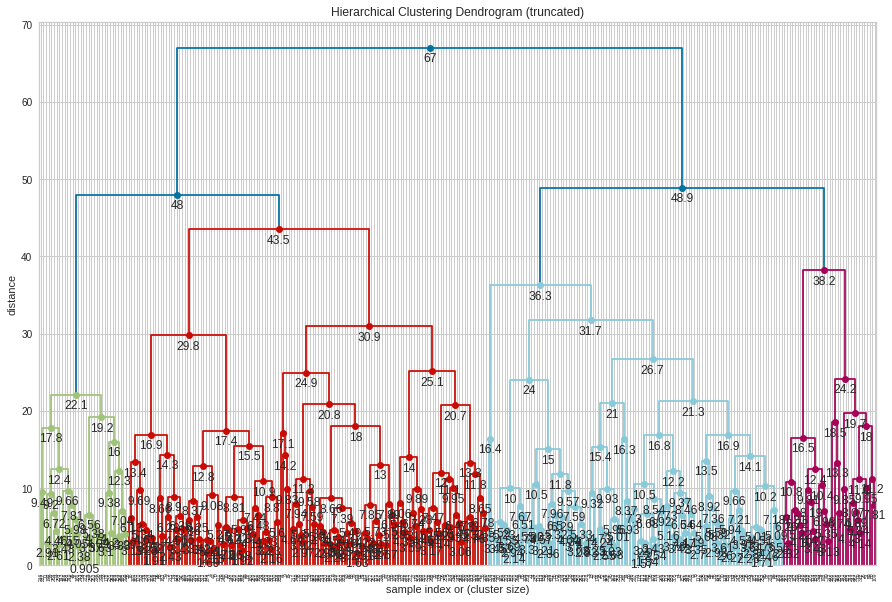

In [0]:
#@title Dendrogram
dendrogram = aa.fancy_dendrogram(sch.linkage(vector_low_dim, method='ward'),
                                 truncate_mode='lastp',p=800,show_contracted=True,figsize=(15,10)) #single #average #ward

#### Init clustering

In [0]:
n_clusters = 7
comment = ''

#### Hierarchical Clustering

In [0]:
model = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward').fit(vector_low_dim)
labels = model.labels_

clusters_df = pd.DataFrame({'terms':terms_flat,'clusters':labels})
clusters_df.to_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)

model = AgglomerativeClustering(n_clusters=n_clusters,affinity='cosine',linkage='average').fit(vectors_flat)
labels = model.labels_

clusters_df = pd.DataFrame({'terms':terms_flat,'clusters':labels})
clusters_df.to_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'agglomarative cosine average '+period+' '+str(n_clusters)+comment+'.csv',index=False)

#### K-means Clustering

In [0]:
model = KMeans(n_clusters=n_clusters, random_state=10).fit(vector_low_dim)
labels = model.labels_

clusters_df = pd.DataFrame({'terms':terms_flat,'clusters':labels})
clusters_df.to_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'kmeans '+period+' '+str(n_clusters)+comment+'.csv',index=False)

#### Visualize cluster

Read saved clusters

In [0]:
cluster_file_name = 'drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'agglomerative ward '+period+' '+str(n_clusters)+comment
cluster_file_name

'drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/15D/10 dim/agglomerative ward 1990-2004 7'

In [0]:
clusters_df = pd.read_csv(cluster_file_name+'.csv')
clusters_df = clusters_df[clusters_df['terms'].isin(terms_flat)]
color_palette = aa.color_palette_maker(n_clusters)
colors = aa.cluster_color_mapper(clusters_df['clusters'].values.tolist(),color_palette)
clusters_df['colors'] = colors

Feature select (for 2D scatter plot)

In [0]:
pca = PCA(2)
pca.fit(vector_low_dim)
#pca.n_components_
vector_low_dim = pca.transform(vector_low_dim)
vector_low_dim[:,1].shape

(314,)

##### Visualize

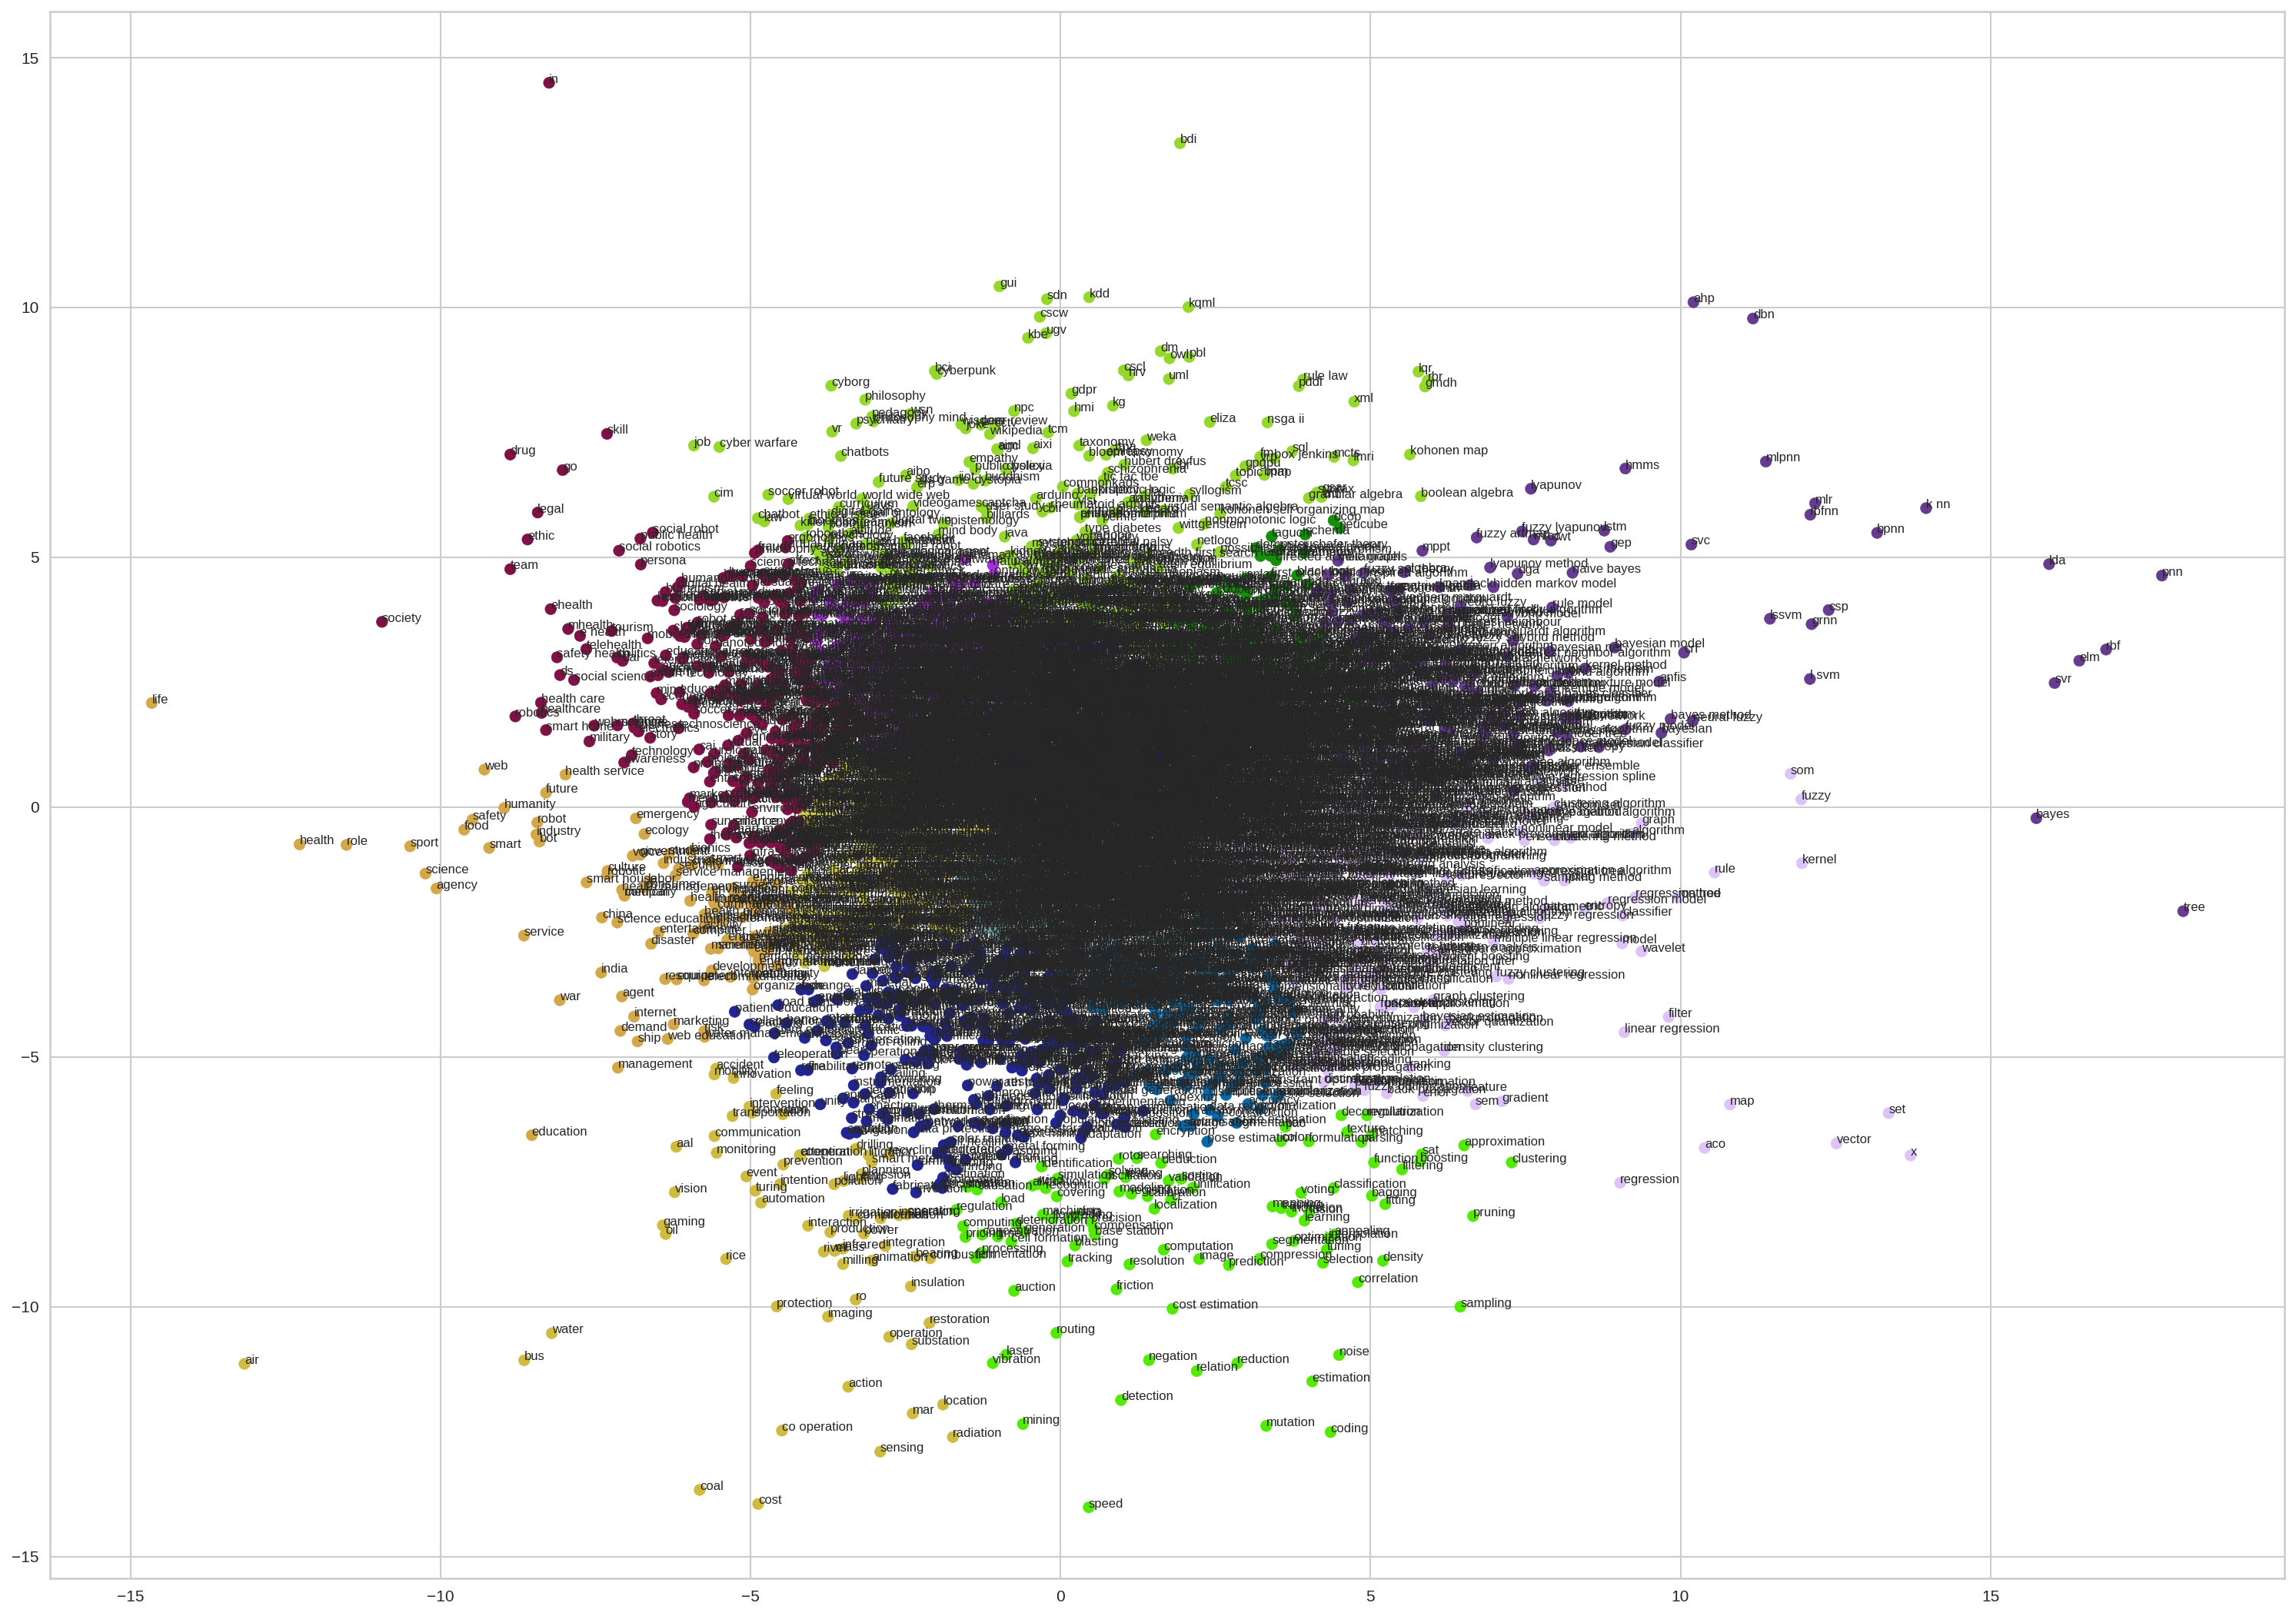

In [0]:
fig, ax = plt.subplots(figsize=(25, 18), dpi=150)
ax.scatter(vector_low_dim[:,0], vector_low_dim[:,1],color = colors)
for i, label in enumerate(terms_flat):
    ax.annotate(label, (vector_low_dim[i,0], vector_low_dim[i,1]), fontsize=8, fontweight='ultralight')

fig.savefig(cluster_file_name+'.jpg')

##### Visualize - reduced samples

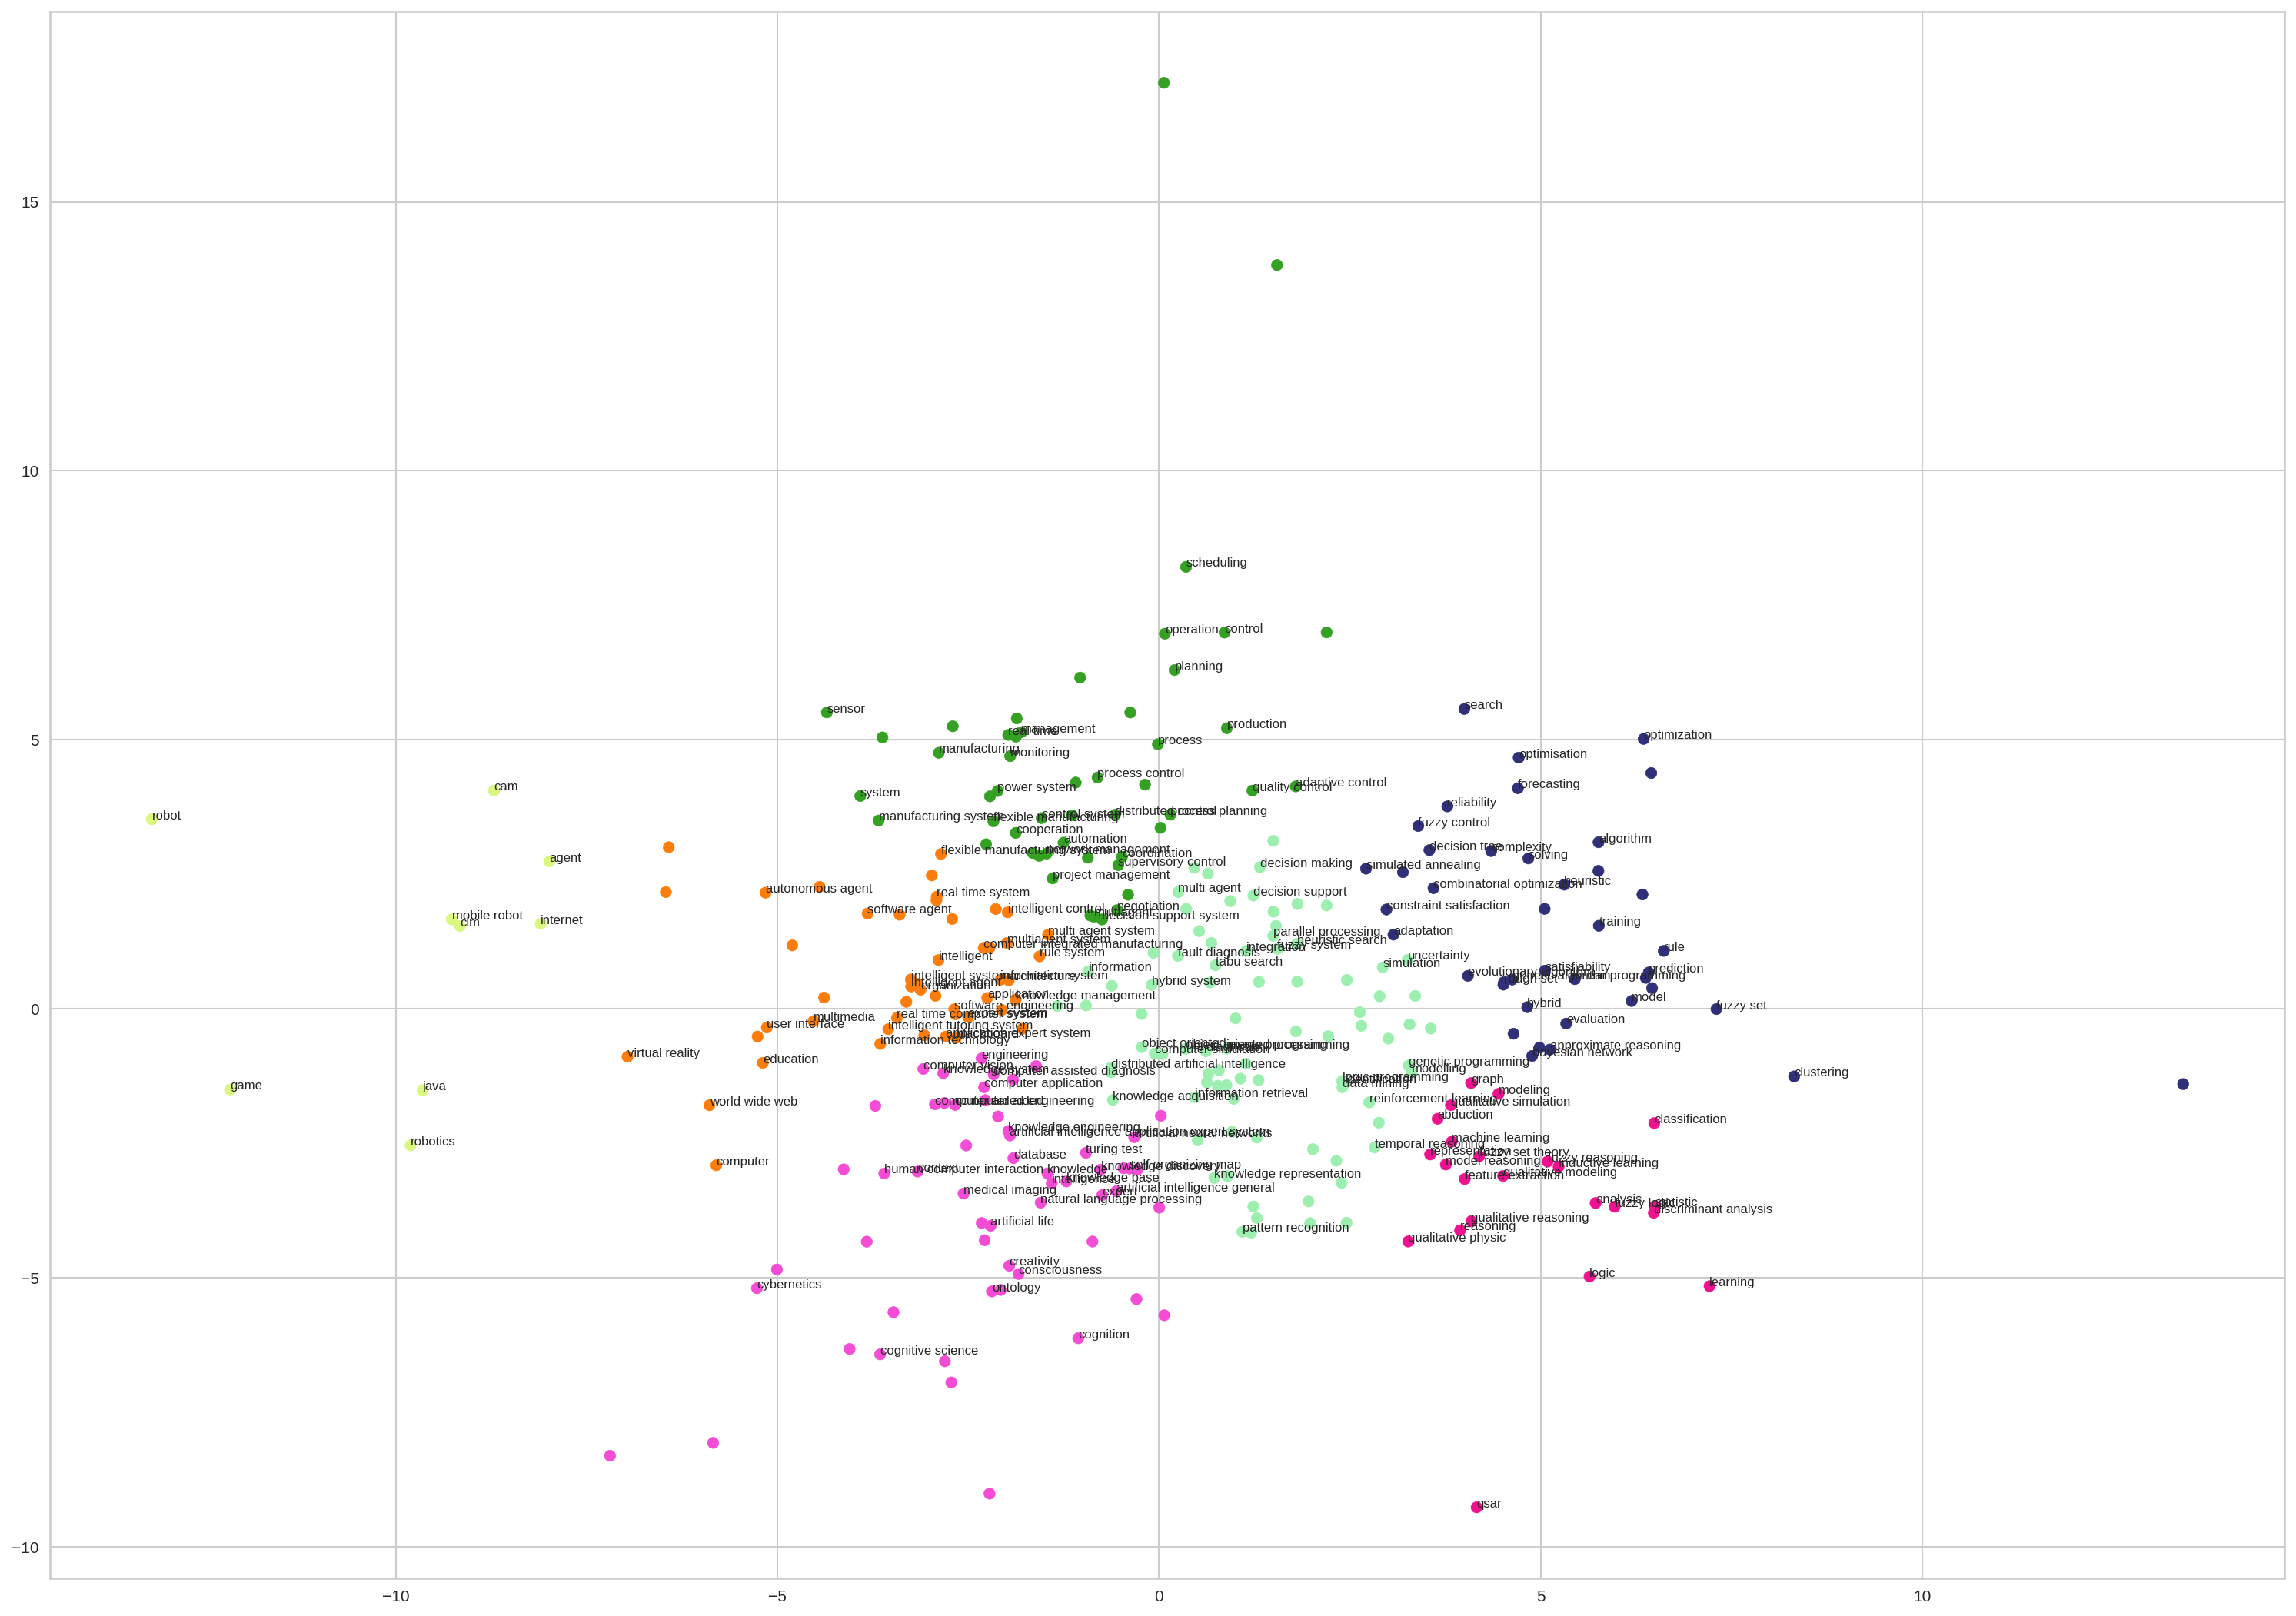

In [0]:
whitelist = []
for idx in range(len(clusters_df.groupby('clusters').groups)):
    whitelist = whitelist + clusters_df['terms'][list(clusters_df.groupby('clusters').groups[idx])].head(30).values.tolist()

fig, ax = plt.subplots(figsize=(25, 18), dpi=150)
ax.scatter(vector_low_dim[:,0], vector_low_dim[:,1],color = colors)
for i, label in enumerate(terms_flat):
    if label in whitelist:
        ax.annotate(label, (vector_low_dim[i,0], vector_low_dim[i,1]), fontsize=8, fontweight='ultralight')

fig.savefig(cluster_file_name+' - reduced labels.jpg')

### Word Cluster Cloud

In [0]:
dim = '15'
period = '1990-2016'
n_clusters = 4
# method = 'kmeans '
method = 'agglomerative ward '
comment = ''
# comment = ' visually_assessed'

Load corpus for the period

In [0]:
path = 'drive/My Drive/Data/corpus/improved_copyr_lemmatized_stopwords_removed_thesaurus_n-grams/'+period+' corpus abstract-title - with n-grams'
corpus = pd.read_csv(path,names=['abstract'])
path

'drive/My Drive/Data/corpus/improved_copyr_lemmatized_stopwords_removed_thesaurus_n-grams/1990-2016 corpus abstract-title - with n-grams'

Load cluster for the period

In [0]:
path = 'drive/My Drive/Data/FastText term clusters/'+dim+'D/'+method+period+' '+str(n_clusters)+comment+'.csv'
clusters = pd.read_csv(path)
path

'drive/My Drive/Data/FastText term clusters/15D/agglomerative ward 1990-2016 4.csv'

Mask the corpus terms by cluster terms

In [0]:
cluster_corpora = []
for cluster_label in range(n_clusters):
    white_list = clusters[clusters['clusters']==cluster_label].terms.values.tolist()
    cluster_corpus = []
    for abstract in tqdm(corpus.abstract,total=corpus.abstract.shape[0]):
        tokenized_abstract = abstract.split()
        cluster_corpus.append(' '.join([token for token in tokenized_abstract if token in white_list]))
    cluster_corpora.append(cluster_corpus)

100%|██████████| 25052/25052 [02:08<00:00, 194.33it/s]


Generate word cloud for each cluster

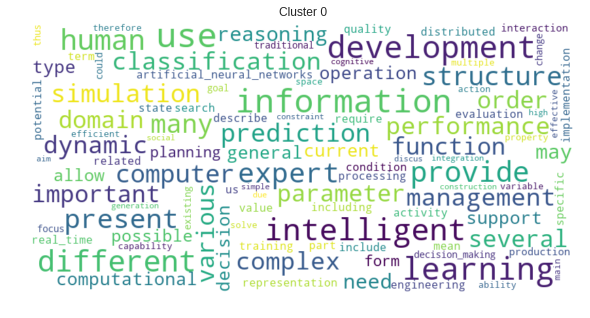

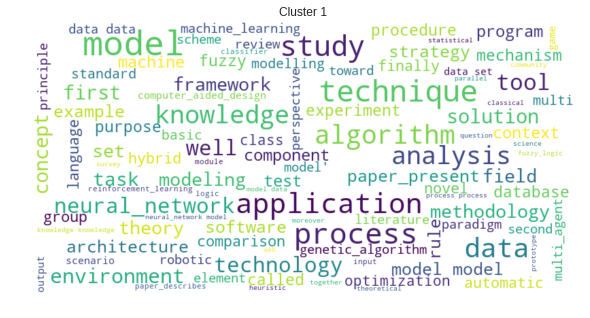

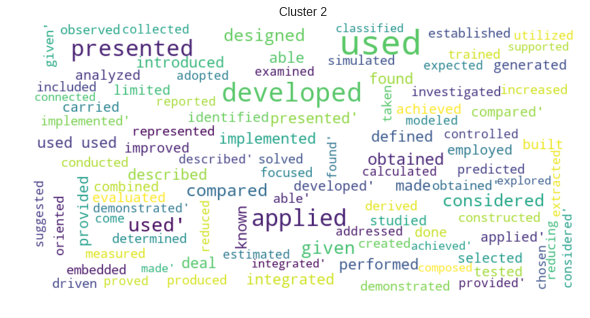

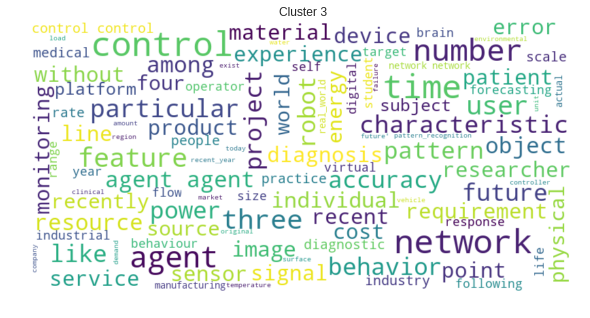

In [0]:
for cluster_label in range(n_clusters):
    wordcloud = WordCloud(background_color='white',
                        stopwords=stop_words,
                        max_words=100,
                        max_font_size=50, 
                        width=800, height=400,
                        random_state=42).generate(str(cluster_corpora[cluster_label]))
    fig = plt.figure(1)
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis('off')
    plt.title('Cluster '+str(cluster_label))
    plt.tight_layout(pad=0)
    plt.show()
    fig.savefig('drive/My Drive/Data/FastText term clusters/'+dim+'D/wordcloud/'+period+' '+method+' cluster_'+str(cluster_label+1)+'.png', dpi=500)

## Word Cluster Center Calculator

### Read clusters

In [0]:
# n_clusters = 8
# sub_dim = '10 dim/'
comment = ''
cluster_file_name = 'drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'agglomerative ward '+period+' '+str(n_clusters)+comment

clusters_df = pd.read_csv(cluster_file_name+'.csv')
clusters_df = clusters_df[clusters_df['terms'].isin(terms_flat)]
# color_palette = aa.color_palette_maker(n_clusters)
# colors = aa.cluster_color_mapper(clusters_df['clusters'].values.tolist(),color_palette)
# clusters_df['colors'] = colors

In [0]:
clusters_df

terms  clusters
0    artificial neural networks         0
1                 expert system         0
2             genetic algorithm         4
3                        expert         3
4                   fuzzy logic         2
..                          ...       ...
386        programming language         2
387           anomaly detection         3
388            search algorithm         4
389                       ethic         0
390          learning algorithm         4

[391 rows x 2 columns]

### Find cluster centre

In [0]:
cluster_centers = []
for cluster in tqdm(range(n_clusters),total=n_clusters):
    cluster_centers.append(vectors_flat[clusters_df[clusters_df['clusters']==cluster].index].mean(axis=0))
pd.DataFrame(cluster_centers).to_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'cluster_centers/cluster_centers - agglomerative ward '+period+' '+str(n_clusters)+comment)


100%|██████████| 7/7 [00:00<00:00, 705.03it/s]


In [0]:
!ls 'drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/15D/10 dim/cluster_centers/'

## Cluster Center Similarity Calculator

Load clusters

In [0]:
sub_dim = '10 dim/'#@param {type:"string"} 
dim = '15'#@param {type:"string"} 
comment = ''#@param {type:"string"} 
# dim_comment = ''

period_A = '1990-2004'#@param {type:"string"} 
n_clusters_A = 7#@param {type:"number"} 

period_B = '1990-2010'#@param {type:"string"} 
n_clusters_B = 10#@param {type:"number"} 

clusters_A = pd.read_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'cluster_centers/cluster_centers - agglomerative ward '+period_A+' '+str(n_clusters_A)+comment,index_col=0)
clusters_B = pd.read_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'cluster_centers/cluster_centers - agglomerative ward '+period_B+' '+str(n_clusters_B)+comment,index_col=0)


### Cosine similarity calculation from period A to period B with following format:


```
cluster_1,cluster_2_0,similarity_0,cluster_2_1,similarity_1,cluster_2_2,similarity_2,cluster_2_3,similarity_3,cluster_2_4,similarity_4
0,0,0.8512495748329945,1,0.9026553867095742,2,0.9891524888487816,3,0.8417661013507162,4,0.9009857248135538
1,0,0.945069537373128,1,0.9293686285273433,2,0.9089606504506658,3,0.9068286759630998,4,0.8822693454546485
2,0,0.8889985179190727,1,0.6474221422202824,2,0.717458586171551,3,0.7027810005644912,4,0.5373087435431511



```



In [0]:
names = []
names.append('cluster_1')
sim_A_to_B = []
for idx_A,vector_A in clusters_A.iterrows():
    inner_similarity_scores = []
    inner_similarity_scores.append(idx_A)
    for idx_B,vector_B in clusters_B.iterrows():
        distance_tmp = spatial.distance.cosine(vector_A.values, vector_B.values)
        similarity_tmp = 1 - distance_tmp

        inner_similarity_scores.append(idx_B)
        inner_similarity_scores.append(similarity_tmp)

        if idx_A == 0:
            names.append('cluster_2_'+str(idx_B))
            names.append('similarity_'+str(idx_B))

    sim_A_to_B.append(inner_similarity_scores)
        # print('cluster of A:',idx_A,'to cluster of B:',idx_B,'similarity',similarity_tmp)

sim_A_to_B = pd.DataFrame(sim_A_to_B,columns=names)
sim_A_to_B.to_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'similarity/agglomerative ward '+period_A+'_'+str(n_clusters_A)+'-'+period_B+'_'+str(n_clusters_B)+'.csv',index=False)

### Euclidean similarity calculation

In [0]:
names = []
names.append('cluster_1')
sim_A_to_B = []
for idx_A,vector_A in clusters_A.iterrows():
    inner_similarity_scores = []
    inner_similarity_scores.append(idx_A)
    for idx_B,vector_B in clusters_B.iterrows():
        # distance_tmp = spatial.distance.euclidean(vector_A.values, vector_B.values) # automatic calculation
        distance_tmp = np.linalg.norm(vector_A.values-vector_B.values) # manual calculation
        similarity_tmp = distance_tmp
        # similarity_tmp = 1 - distance_tmp


        inner_similarity_scores.append(idx_B)
        inner_similarity_scores.append(similarity_tmp)

        if idx_A == 0:
            names.append('cluster_2_'+str(idx_B))
            names.append('similarity_'+str(idx_B))

    sim_A_to_B.append(inner_similarity_scores)
        # print('cluster of A:',idx_A,'to cluster of B:',idx_B,'similarity',similarity_tmp)

sim_A_to_B = pd.DataFrame(sim_A_to_B,columns=names)
sim_A_to_B.to_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'similarity/agglomerative ward '+period_A+'_'+str(n_clusters_A)+'-'+period_B+'_'+str(n_clusters_B)+' - euclidean.csv',index=False)

## Term Cluster and Term Score Cluster Table Maker

In [0]:
# sub_dim = '10 dim/'
# dim_comment = ' 3pcnt'
# dim = '15'
# period = '1990-2018'
# n_clusters = 8
comment = ''
corpus = pd.read_csv('drive/My Drive/Data/Author keywords - 29 Oct 2019/'+period+' keyword frequency',names=['keyword','frequency'])

cluster_file_name = 'drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'agglomerative ward '+period+' '+str(n_clusters)+comment
clusters = pd.read_csv(cluster_file_name+'.csv')
term_table = clusters.groupby('clusters').groups
# term_table_df = pd.DataFrame([list(clusters['terms'][term_table[x]]) for x in term_table]).T.fillna('')
# score_table_df = [list(corpus[corpus['keyword']==clusters['terms'][term_table[x]]]['frequency']) for x in term_table]

# groups.to_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D/'+sub_dim+'term_cluster-tables/agglomerative ward '+period+' '+str(n_clusters)+comment,index=False)

term_table_df = []
score_table_df = []
for cluster_items in term_table:
    cluster_terms = list(clusters['terms'][term_table[cluster_items]])
    cluster_scores = [corpus[corpus['keyword']==x]['frequency'].values[0] for x in cluster_terms]
    score_table_df.append(cluster_scores)
    term_table_df.append(cluster_terms)
comment = ' - term_cluster'
term_table_df = pd.DataFrame(term_table_df).T.to_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)
comment = ' - term_score'
score_table_df = pd.DataFrame(score_table_df).T.to_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)


# Document Clustering

## Simple averaging

#### Calculate document vectors

In [0]:
article_vectors = []
for idx,article in tqdm(enumerate(period_article_vectors),total=len(period_article_vectors)):
    article_vectors.append(np.array(pd.DataFrame(article).mean().values.tolist()))

100%|██████████| 32857/32857 [12:02<00:00, 45.49it/s]


In [0]:
article_vectors_np = np.array(article_vectors)
article_vectors_np.shape

(32857, 300)

#### Save doc vectors to disk

In [0]:
article_vectors_df = pd.DataFrame(article_vectors_np)
article_vectors_df['article'] = period_article_indices
article_vectors_df.to_csv('drive/My Drive/Data/FastText doc vectors/'+'FastText doc vectors '+period+'.csv')

#### Find out the N-clusters

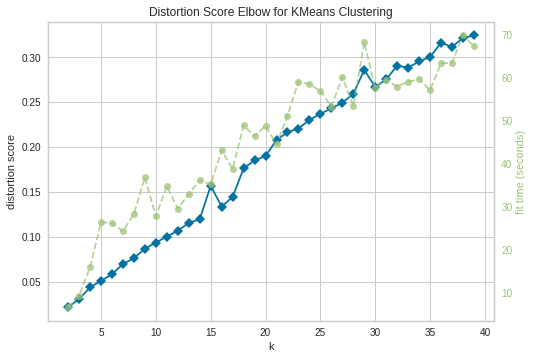

In [0]:
#@title K-Means elbow (Distortion should go down.)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,40))
visualizer.fit(article_vectors_np)                                                    # Fit the data to the visualizer
visualizer.poof()  

  0%|          | 0/14 [00:00<?, ?it/s]

Gridsearching the cluster ranges . . . 


100%|██████████| 14/14 [05:40<00:00, 30.68s/it]


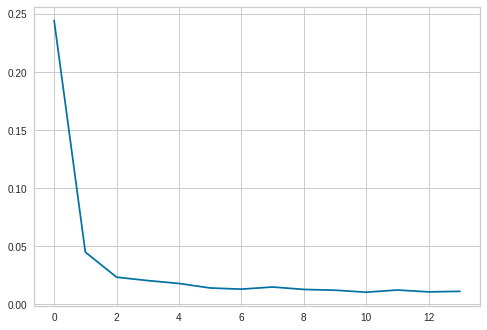

In [0]:
#@title K-Means silhouette score 

silhouette_avg_all = []
cluster_range =list(range(2,30,2))

print("Gridsearching the cluster ranges . . . ")
for n_clusters in tqdm(cluster_range,total=len(cluster_range)):
    # clustering = AgglomerativeClustering(n_clusters=n_clusters,affinity='cosine',linkage='complete').fit(articles_vectors_filtered_np)
    clustering = KMeans(n_clusters=n_clusters, random_state=10).fit(article_vectors_np)
    # clustering = AffinityPropagation().fit(article_vectors_np)
    
    cluster_labels = clustering.labels_
    silhouette_avg = silhouette_score(article_vectors_np, cluster_labels)
    silhouette_avg_all.append(silhouette_avg)

fig = plt.figure()
plt.plot(silhouette_avg_all)
plt.show()

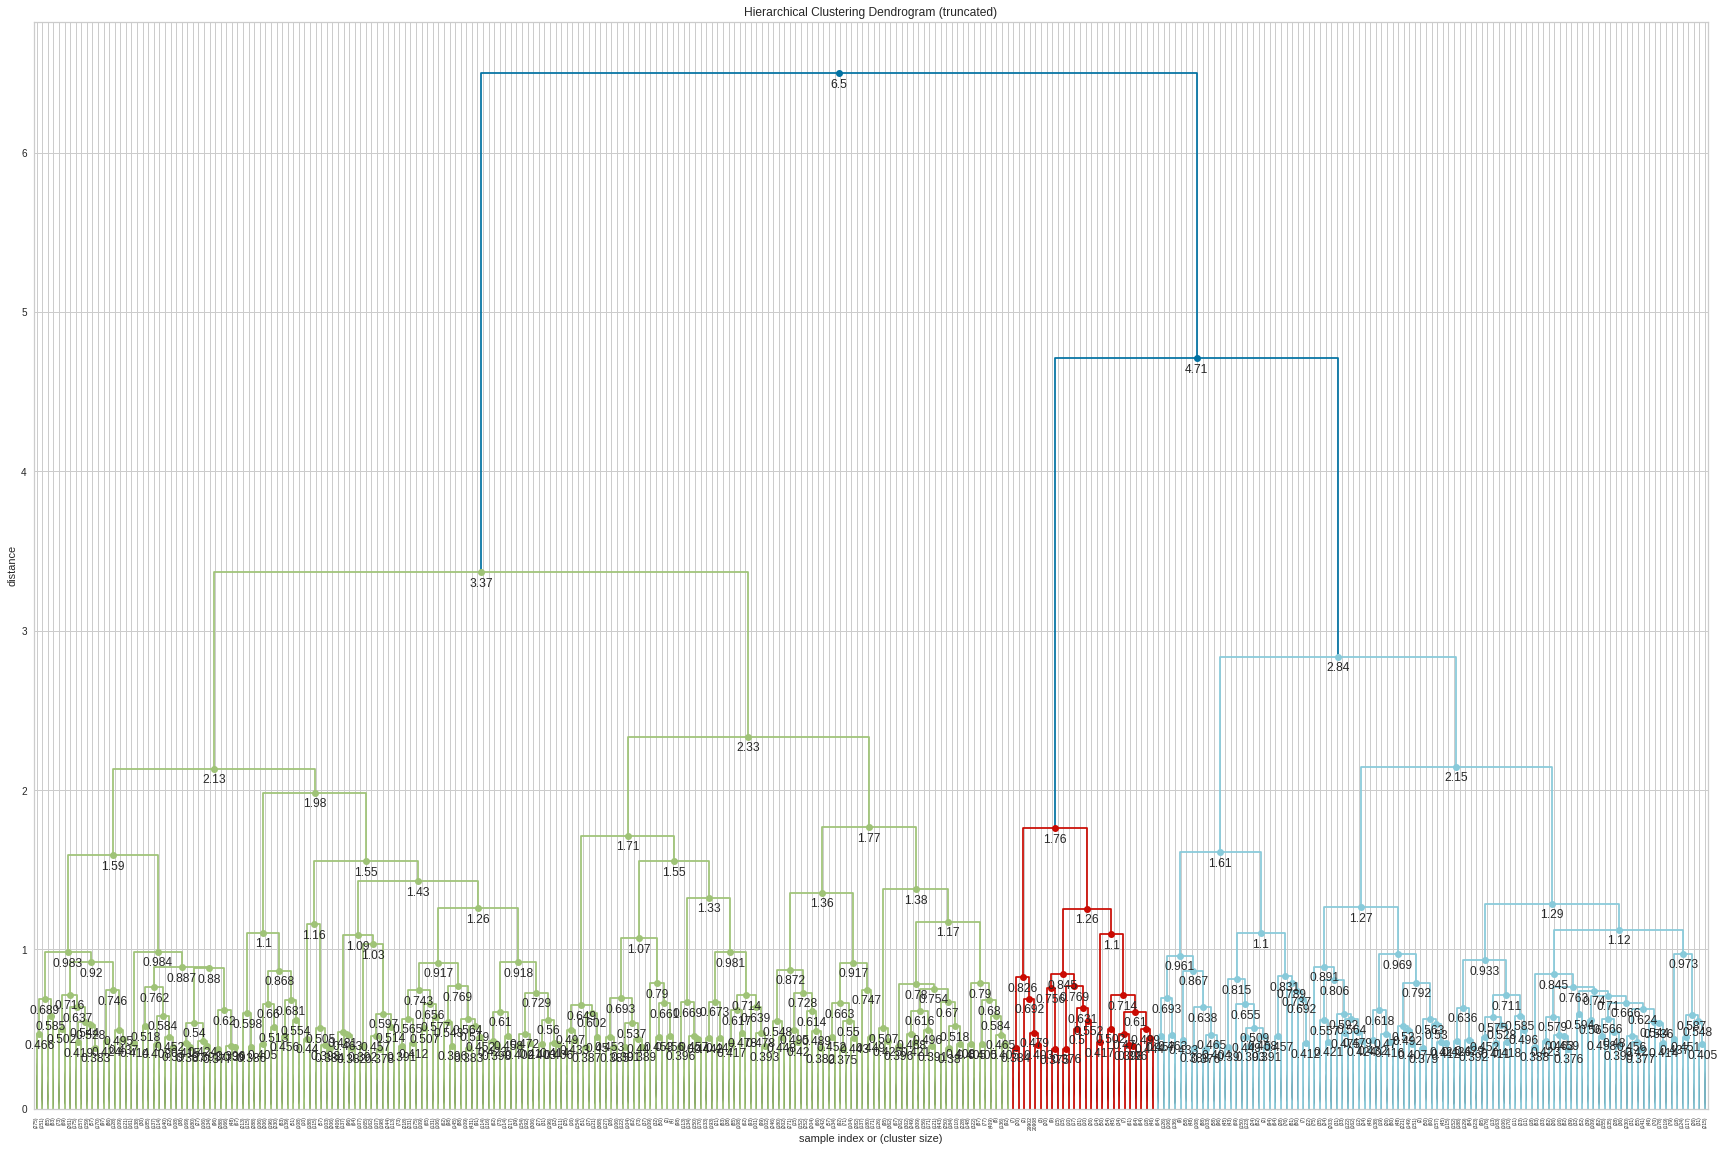

In [0]:
#@title Dendrogram 
dendrogram = aa.fancy_dendrogram(sch.linkage(article_vectors_np, method='ward'),
                                 truncate_mode='lastp',p=300,show_contracted=True,figsize=(30,20)) #single #average #ward

#### Cluster - simple kmeans

In [0]:
n_clusters = 8

model = KMeans(n_clusters=n_clusters, random_state=10).fit(article_vectors_np)
labels = model.labels_

clusters_df = pd.DataFrame({'articles':period_article_indices,'clusters':labels})

clusters_df.to_csv('drive/My Drive/Data/FastText doc clusters/'+'FastText doc clusters kmeans '+period+' '+str(n_clusters)+'.csv',index=False)

## Weighted averaging / SIF

#### Prepare vectors

In [0]:
year_from = 1990#@param {type:"number"} 
year_to =  2017#@param {type:"number"} 
#@markdown Don't forget to set year_to to a yar higher than intended

year_sources = []
year_titles = []
year_vectors = []
year_topics = []
year_topics_sep = []
year_keywords = []
year_keywords_sep = []

period = str(year_from)+'-'+str(year_to-1)

for i,tmp_year in tqdm(enumerate(doc_year),total=doc_year.shape[0]):
    if tmp_year > year_from-1 and tmp_year < year_to:
        tmp_source = doc_sources[i]
        tmp_vector = doc_vectors[i,:]
        tmp_title = doc_titles[i]
        tmp_topics = doc_research_topic[i]
        tmp_keywords = doc_keywords[i]
        year_sources.append(tmp_source)
        year_topics.append(tmp_topics)
        # print(tmp_topics)
        if pd.isnull(tmp_topics):
            year_topics_sep.append('')
        else:
            year_topics_sep.append([x.strip() for x in tmp_topics.split(';')])
        if pd.isnull(tmp_keywords):
            year_keywords_sep.append('')
        else:
            year_keywords_sep.append([x.strip() for x in tmp_keywords.split(';')])
        year_titles.append(tmp_title)
        year_vectors.append(tmp_vector)

year_vectors = np.array(year_vectors)
print('\n',period,year_vectors.shape)

100%|██████████| 32857/32857 [00:00<00:00, 163057.26it/s]


 1990-2016 (25052, 50)


Prepare label names (topics) - Doing this, is faster than using a function to this operation in every loop whenever we need it. However, this and similar things are not memory friendly.

In [0]:
year_topics_sep_joined = []
for pub_topics in tqdm(year_topics_sep):
    if pub_topics == '':
        year_topics_sep_joined.append('*')
    else:
        year_topics_sep_joined.append(';'.join(pub_topics))

100%|██████████| 25052/25052 [00:00<00:00, 1186156.84it/s]


Prepare label names (keywords) - Doing this, is faster than using a function to this operation in every loop whenever we need it. However, this and similar things are not memory friendly.

In [0]:
# Clean keywords
year_keywords_sep = [list(map(str.strip, x)) for x in year_keywords_sep]
year_keywords_sep = [list(map(str.lower, x)) for x in year_keywords_sep]

regex = re.compile("\((.*?)\)")
tmp_data = []
for row in year_keywords_sep:
    tmp_data.append([regex.sub('',x).strip() for x in row])
    
year_keywords_sep = tmp_data.copy()
tmp_data = []
for string_list in tqdm(keywords, total=len(keywords)):
    tmp_data.append([x for x in string_list if x!=''])
year_keywords_sep = tmp_data.copy()
del tmp_data

# Thesaurus
year_keywords_sep = kw.thesaurus_matching(year_keywords_sep,'thesaurus_for_ai_keyword_with_().csv',have_n_grams=True,verbose=0
                                          )
tmp_data = []
for string_list in tqdm(year_keywords_sep, total=len(year_keywords_sep)):
    tmp_data.append([x for x in string_list if x!=''])
year_keywords_sep = tmp_data.copy()
del tmp_data
# Lemmatize

keywords_orig = year_keywords_sep.copy()
tmp_data = []
print("\nString pre processing for keywords")
for string_list in tqdm(year_keywords_sep, total=len(year_keywords_sep)):
    tmp_list = [kw.string_pre_processing(x,stemming_method='False',lemmatization=True,stop_words_extra=stop_words,verbose=False,download_nltk=False) for x in string_list]
    tmp_data.append(tmp_list)
year_keywords_sep = tmp_data
del tmp_data

# Thesaurus
year_keywords_sep = kw.thesaurus_matching(year_keywords_sep,'thesaurus_for_ai_keyword_with_().csv',have_n_grams=False)

tmp_data = []
for string_list in tqdm(year_keywords_sep, total=len(year_keywords_sep)):
    tmp_data.append([x for x in string_list if x!=''])
year_keywords_sep = tmp_data.copy()
del tmp_data



In [0]:
year_keywords_sep_joined = []
for pub_keywords in tqdm(year_keywords_sep):
    if pub_topics == '':
        year_keywords_sep_joined.append('*')
    else:
        year_keywords_sep_joined.append(';'.join(pub_keywords))

100%|██████████| 25052/25052 [00:00<00:00, 936153.17it/s]


### Clustering

#### Find optimal cluster size: Dendrogram method

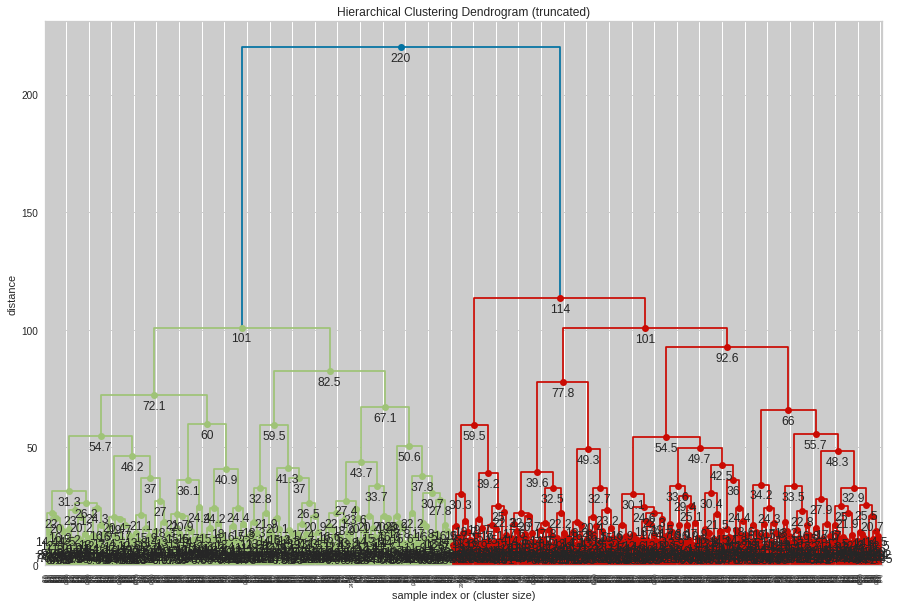

In [0]:
#@title Dendrogram choose either single OR average OR ward
dendrogram = aa.fancy_dendrogram(sch.linkage(year_vectors, method='ward'),
            truncate_mode='lastp',p=800,show_contracted=True,figsize=(15,10)) 

#### Init clustering

In [0]:
n_clusters = 15
top_labeles_to_draw = 6
chance_of_printing_label = 0.3
comment = ''
dim = '50'

#### Cluster

In [0]:
model = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward').fit(year_vectors)
labels = model.labels_

In [0]:
clusters_df = pd.DataFrame({'sources':year_sources,'clusters':labels})
clusters_df.to_csv('drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D/agglomerative ward '+period+' '+str(n_clusters)+'.csv',index=False)

In [0]:
clusters_df = pd.DataFrame({'topic':year_topics_sep_joined,'clusters':labels})
clusters_df.to_csv('drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D/agglomerative ward '+period+' '+str(n_clusters)+' - topic_labels.csv',index=False)

In [0]:
plus = ''
# plus = ' -plus'
clusters_df = pd.DataFrame({'topic':year_topics_sep_joined,'clusters':labels})
clusters_df.to_csv('drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D/agglomerative ward '+period+' '+str(n_clusters)+' - keyword_labels.csv',index=False)

#### Visualize clusters - with source labels

In [0]:
cluster_file_name = 'drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D/agglomerative ward '+period+' '+str(n_clusters)+'.csv'
cluster_file_name

'drive/My Drive/Data/FastText doc clusters - SIP/50D/agglomerative ward 1990-2007 10.csv'

In [0]:
clusters_df = pd.read_csv(cluster_file_name)
clusters_df = clusters_df[clusters_df['sources'].isin(year_sources)]
color_palette = aa.color_palette_maker(n_clusters)
colors = aa.cluster_color_mapper(clusters_df['clusters'].values.tolist(),color_palette)
clusters_df['colors'] = colors

In [0]:
pca = PCA(2)
pca.fit(year_vectors)
#pca.n_components_
vector_low_dim = pca.transform(year_vectors)
vector_low_dim[:,1].shape

(10556,)

##### Draw with sources as labels

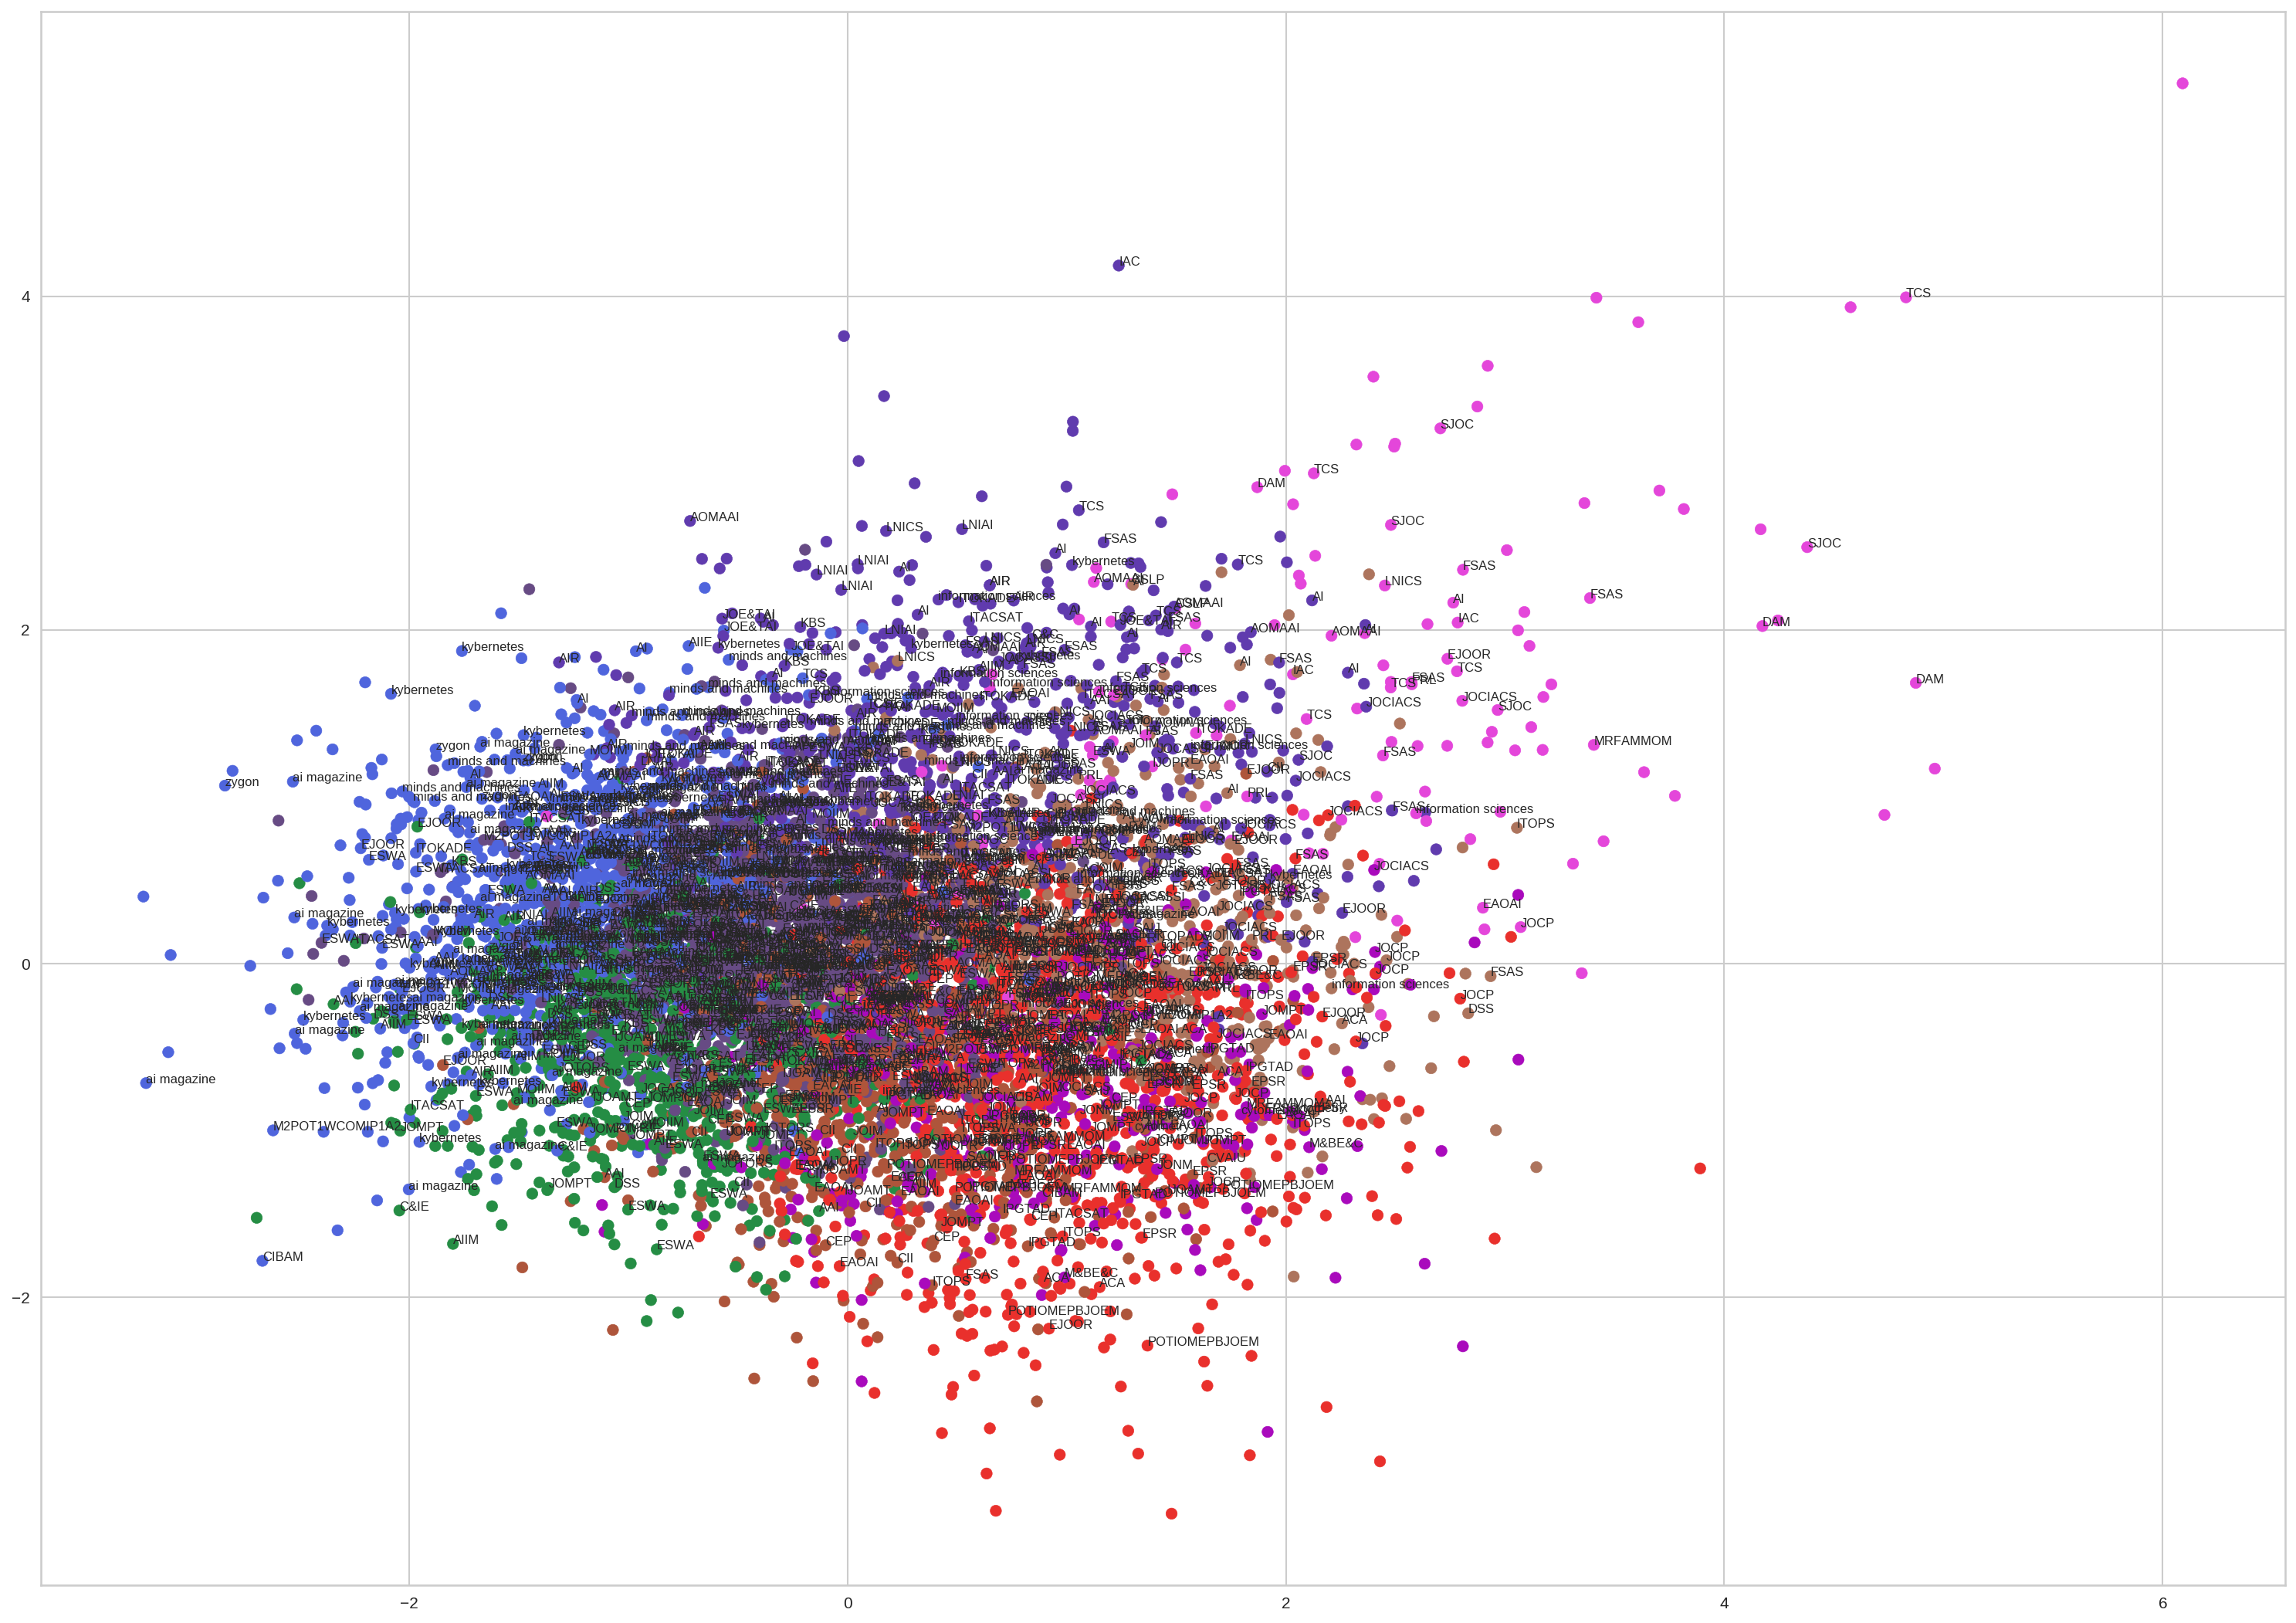

In [0]:
whitelist = []
for idx in range(len(clusters_df.groupby('clusters').groups)):
    # Get sources for this cluster
    this_cluster_df = clusters_df.iloc[list(clusters_df.groupby('clusters').groups[idx])]
    # Group sources to get unique source names and sort them by frequency
    source_counts = this_cluster_df.groupby('sources').count()['clusters'].reset_index().sort_values(by=['clusters'], ascending=False)
    source_counts.columns = ['sources','frequency']
    # Get top N sources by frequency
    whitelist = whitelist + source_counts['sources'].head(top_labeles_to_draw).values.tolist()

fig, ax = plt.subplots(figsize=(25, 18), dpi=150)
ax.scatter(vector_low_dim[:,0], vector_low_dim[:,1],color = colors)
year_sources_abbr = []
year_sources_orig = []
for i, label in enumerate(year_sources):
    if label in whitelist:
        if len(label)>20:
            year_sources_orig.append(label)
            label = aa.abbreviator(label)
            year_sources_abbr.append(label)

        ax.annotate(label, (vector_low_dim[i,0], vector_low_dim[i,1]), fontsize=8, fontweight='ultralight')

fig.savefig(cluster_file_name[:-4]+' - reduced labels.jpg')

In [0]:
year_sources_abbr = pd.DataFrame(year_sources_abbr)
year_sources_abbr['original'] = year_sources_orig
year_sources_abbr.columns = ['abbreviation','original']
year_sources_abbr.to_csv(cluster_file_name[:-4]+' - labels guide.csv')
year_sources_abbr

abbreviation                                           original
0            NC&A                    neural computing & applications
1           CIBAM                  computers in biology and medicine
2          CMAPIB       computer methods and programs in biomedicine
3            C&IE                 computers & industrial engineering
4             ASC                             applied soft computing
...           ...                                                ...
2387         AIIM                artificial intelligence in medicine
2388       IJOAMT  international journal of advanced manufacturin...
2389         C&OR                    computers & operations research
2390        EAOAI  engineering applications of artificial intelli...
2391         ESWA                   expert systems with applications

[2392 rows x 2 columns]

#### Visualize clusters - with topic labels

In [0]:
cluster_file_name = 'drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D/agglomerative ward '+period+' '+str(n_clusters)+' - topic_labels.csv'
cluster_file_name

'drive/My Drive/Data/FastText doc clusters - SIP/50D/agglomerative ward 1990-2016 15 - topic_labels.csv'

In [0]:
clusters_df = pd.read_csv(cluster_file_name)
# clusters_df = clusters_df[clusters_df['topic']!='*']
color_palette = aa.color_palette_maker(n_clusters)
colors = aa.cluster_color_mapper(clusters_df['clusters'].values.tolist(),color_palette)
clusters_df['colors'] = colors


In [0]:
pca = PCA(2)
pca.fit(year_vectors)
#pca.n_components_
vector_low_dim = pca.transform(year_vectors)
vector_low_dim[:,1].shape

(25052,)

##### Draw with topics as labels

In [0]:
whitelist = []
for idx in range(len(clusters_df.groupby('clusters').groups)):
    # Get indices for this cluster
    this_cluster_df = clusters_df.iloc[list(clusters_df.groupby('clusters').groups[idx])]
    # Flatten topics of cluster
    cluster_topics = [x.split(';') for x in this_cluster_df['topic'].to_list()]
    topics = pd.DataFrame([j for sub in cluster_topics for j in sub])
    topics.columns = ['topic']
    # Group topics to get unique source names and sort them by frequency
    g_tmp = pd.DataFrame(topics['topic'].value_counts()).reset_index()
    g_tmp.columns = ['topic','count']
    g_tmp = g_tmp.sort_values(by=['count'], ascending=False)
    # Get top N sources by frequency
    whitelist = whitelist + g_tmp['topic'].head(top_labeles_to_draw).values.tolist()
    if idx == 0:
        top_topic = g_tmp.head(15).copy()
    else:
        top_topic = pd.concat([top_topic, g_tmp.head(15)], axis=1)
whitelist = [element for element in whitelist if element!='computer science']
top_topic

topic  ...  count
0                           computer science  ...  373.0
1                                engineering  ...  268.0
2               automation & control systems  ...   45.0
3   operations research & management science  ...   38.0
4                                mathematics  ...   35.0
5                             energy & fuels  ...   27.0
6                          materials science  ...   24.0
7           environmental sciences & ecology  ...   22.0
8                       business & economics  ...   22.0
9              instruments & instrumentation  ...   19.0
10                                 chemistry  ...   16.0
11                           water resources  ...   15.0
12                        telecommunications  ...   13.0
13                                  robotics  ...   10.0
14                                   physics  ...   10.0
15                                       NaN  ...    NaN

[16 rows x 30 columns]

In [0]:
top_topic.to_csv(cluster_file_name[:-4]+' - topic cluster frequency.csv')

In [0]:
fig, ax = plt.subplots(figsize=(30, 20), dpi=200)
ax.scatter(vector_low_dim[:,0], vector_low_dim[:,1],color = colors)
year_sources_abbr = []
year_sources_orig = []
for i, topics_joined in enumerate(year_topics_sep_joined):
    if any(element in whitelist for element in topics_joined.split(';')):
        if random()<=chance_of_printing_label:
            ax.annotate(topics_joined, (vector_low_dim[i,0], vector_low_dim[i,1]), fontsize=8, fontweight='ultralight')

fig.savefig(cluster_file_name[:-4]+' - reduced labels - topic labels.jpg')

#### Visualize clusters - with keyword labels

In [333]:
cluster_file_name = 'drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D/agglomerative ward '+period+' '+str(n_clusters)+' - topic_labels.csv'
cluster_file_name

'drive/My Drive/Data/FastText doc clusters - SIP/50D/agglomerative ward 1990-2016 15 - keyword_labels.csv'

In [0]:
clusters_df = pd.read_csv(cluster_file_name)
# clusters_df = clusters_df[clusters_df['topic']!='*']
color_palette = aa.color_palette_maker(n_clusters)
colors = aa.cluster_color_mapper(clusters_df['clusters'].values.tolist(),color_palette)
clusters_df['colors'] = colors


In [335]:
pca = PCA(2)
pca.fit(year_vectors)
#pca.n_components_
vector_low_dim = pca.transform(year_vectors)
vector_low_dim[:,1].shape

(25052,)

In [0]:
whitelist = []
keywords_terms = []
keywords_frequencies = []

for idx in range(len(clusters_df.groupby('clusters').groups)):
    # Get indices for this cluster
    this_cluster_df = clusters_df.iloc[list(clusters_df.groupby('clusters').groups[idx])]
    # Flatten topics of cluster
    cluster_topics = [x.split(';') for x in this_cluster_df['topic'].to_list()]
    topics = pd.DataFrame([j for sub in cluster_topics for j in sub])
    topics.columns = ['topic']
    # Group topics to get unique source names and sort them by frequency
    g_tmp = pd.DataFrame(topics['topic'].value_counts()).reset_index()
    g_tmp.columns = ['topic','count']
    g_tmp = g_tmp.sort_values(by=['count'], ascending=False)
    # Get top N sources by frequency
    whitelist = whitelist + g_tmp['topic'].head(top_labeles_to_draw).values.tolist()
    tmp_temrs = []
    tmp_freqs = []
    for i,x in enumerate(g_tmp['topic'].tolist()):
        if x!='':
            tmp_temrs.append(x)
            tmp_freqs.append(g_tmp['count'].tolist()[i])
    if idx == 0:
        top_topic = g_tmp.head(15).copy()
    else:
        top_topic = pd.concat([top_topic, g_tmp.head(15)], axis=1)
    keywords_terms.append(tmp_terms)
    keywords_frequencies.append(tmp_freqs)
    
whitelist = [element for element in whitelist if element!='computer science']
top_topic

In [0]:
top_topic.to_csv(cluster_file_name[:-4]+' - keyword cluster frequency.csv')

In [0]:
fig, ax = plt.subplots(figsize=(30, 20), dpi=200)
ax.scatter(vector_low_dim[:,0], vector_low_dim[:,1],color = colors)
year_sources_abbr = []
year_sources_orig = []
for i, topics_joined in enumerate(year_topics_sep_joined):
    if any(element in whitelist for element in topics_joined.split(';')):
        if random()<=chance_of_printing_label:
            ax.annotate(topics_joined, (vector_low_dim[i,0], vector_low_dim[i,1]), fontsize=8, fontweight='ultralight')

fig.savefig(cluster_file_name[:-4]+' - reduced labels - keyword labels.jpg')

### Cluster Center Calc

In [0]:
sub_dim = ''
# dim = '50'
dim_comment = ''
n_clusters = 9#@param {type:"number"} 
# period = '1990-2004' 
#@markdown Period should be set at vector year preparation section!!
comment = ''

cluster_file_name = 'drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'agglomerative ward '+period+' '+str(n_clusters)+comment

clusters_df = pd.read_csv(cluster_file_name+'.csv')
# color_palette = aa.color_palette_maker(n_clusters)
# colors = aa.cluster_color_mapper(clusters_df['clusters'].values.tolist(),color_palette)
# clusters_df['colors'] = colors

vectors_df = pd.DataFrame(year_vectors)

if(clusters_df.shape[0] != vectors_df.shape[0]):
    print('Fix year vector section. periods here should be set from that section.')
else:
    print('Good to go!')

Good to go!


In [0]:
cluster_centers = []
for cluster in tqdm(range(n_clusters),total=n_clusters):
    cluster_centers.append(vectors_df.iloc[clusters_df[clusters_df['clusters']==cluster].index].mean(axis=0))
pd.DataFrame(cluster_centers).to_csv('drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'cluster_centers/agglomerative ward '+period+' '+str(n_clusters)+comment)


100%|██████████| 9/9 [00:00<00:00, 526.72it/s]


### Cluster Similarity Calc

In [0]:
sub_dim = ''
dim = '50'#@param {type:"string"} 
dim_comment = ''
comment = ''#@param {type:"string"} 

period_A = '1990-2004'#@param {type:"string"} 
n_clusters_A = 15#@param {type:"number"} 

period_B = '1990-2018'#@param {type:"string"} 
n_clusters_B = 15#@param {type:"number"} 

clusters_A = pd.read_csv('drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'cluster_centers/agglomerative ward '+period_A+' '+str(n_clusters_A)+comment,index_col=0)
clusters_B = pd.read_csv('drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'cluster_centers/agglomerative ward '+period_B+' '+str(n_clusters_B)+comment,index_col=0)


In [0]:
names = []
names.append('cluster_1')
sim_A_to_B = []
for idx_A,vector_A in clusters_A.iterrows():
    inner_similarity_scores = []
    inner_similarity_scores.append(idx_A)
    for idx_B,vector_B in clusters_B.iterrows():
        distance_tmp = spatial.distance.cosine(vector_A.values, vector_B.values)
        similarity_tmp = 1 - distance_tmp

        inner_similarity_scores.append(idx_B)
        inner_similarity_scores.append(similarity_tmp)

        if idx_A == 0:
            names.append('cluster_2_'+str(idx_B))
            names.append('similarity_'+str(idx_B))

    sim_A_to_B.append(inner_similarity_scores)
        # print('cluster of A:',idx_A,'to cluster of B:',idx_B,'similarity',similarity_tmp)

sim_A_to_B = pd.DataFrame(sim_A_to_B,columns=names)
sim_A_to_B.to_csv('drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'similarity/agglomerative ward '+period_A+'_'+str(n_clusters_A)+'-'+period_B+'_'+str(n_clusters_B)+'.csv',index=False)

### Term-cluster tables

In [0]:
sub_dim = ''#@param {type:"string"} 
dim_comment = ''#@param {type:"string"} 
dim = '50'#@param {type:"string"} 
n_clusters = 9#@param {type:"number"} 
comment = ''
save_frequency_to_disk = False #@param {type:"boolean"}

cluster_file_name = 'drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'agglomerative ward '+period+' '+str(n_clusters)+comment
clusters = pd.read_csv(cluster_file_name+'.csv')
term_table = clusters.groupby('clusters').groups

year_sources_df = pd.DataFrame(year_sources)
year_sources_df['clusters'] = clusters['clusters']
year_sources_df.columns = ['sources','clusters']
year_sources_df = year_sources_df.groupby('sources').count()['clusters'].reset_index().sort_values(by=['clusters'], ascending=False)
year_abbreviations = []

for item in tqdm(year_sources_df['sources'],total=year_sources_df.shape[0]):
    year_abbreviations.append(aa.abbreviator(item))

year_sources_df.columns = ['sources','frequency']
year_sources_df['sources_abbr'] = year_abbreviations

if save_frequency_to_disk is True:
    save_dest_address = 'drive/My Drive/Data/corpus/improved_copyr_lemmatized_stopwords_removed_thesaurus_n-grams/source_frequency_abbr.csv'#@param {type:"string"}
    year_sources_df.to_csv(save_dest_address,index=False)

100%|██████████| 2866/2866 [00:00<00:00, 211832.79it/s]


In [0]:
# term_table_df = pd.DataFrame([list(clusters['terms'][term_table[x]]) for x in term_table]).T.fillna('')
# score_table_df = [list(corpus[corpus['keyword']==clusters['terms'][term_table[x]]]['frequency']) for x in term_table]

# groups.to_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D/'+sub_dim+'term_cluster-tables/agglomerative ward '+period+' '+str(n_clusters)+comment,index=False)

term_table_df = []
score_table_df = []
for cluster_items in tqdm(term_table,total=len(term_table)):
    cluster_terms = list(clusters['sources'][term_table[cluster_items]])
    cluster_scores = [year_sources_df[year_sources_df['sources']==x]['frequency'].values[0] for x in cluster_terms]
    score_table_df.append(cluster_scores)
    term_table_df.append(cluster_terms)
comment = ' - term_cluster'
term_table_df = pd.DataFrame(term_table_df).T.to_csv('drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)
comment = ' - term_score'
score_table_df = pd.DataFrame(score_table_df).T.to_csv('drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)


100%|██████████| 9/9 [00:07<00:00,  1.40it/s]


#### Term-cluster tables: keywords

In [0]:
sub_dir = 'authkeywor'
# sub_dir = 'keywordplus'
comment = ' - term_cluster'
pd.DataFrame(keywords_terms).T.to_csv('drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/'+sub_dir+'agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)
comment = ' - term_score'
pd.DataFrame(keywords_frequencies).T.to_csv('drive/My Drive/Data/FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/'+sub_dir+'agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)